In [119]:
import tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from keras_core import Sequential
from keras_core.models import Model
from keras_core.layers import Dense, Conv2D, ReLU, BatchNormalization, Add, Input, Resizing, Flatten, AveragePooling2D, Dropout, MaxPooling2D
from keras_core.optimizers import Adam, SGD, Adamax
from keras_core.optimizers.schedules import ExponentialDecay

In [2]:
# Reading
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_val = pd.read_csv('./data/val.csv')

In [3]:
df_train['Data'] = df_train['Image'].apply(lambda x: imread(f'./data/train_images/{x}'))
df_test['Data'] = df_test['Image'].apply(lambda x: imread(f'./data/test_images/{x}'))
df_val['Data'] = df_val['Image'].apply(lambda x: imread(f'./data/val_images/{x}'))

In [4]:
scaler = StandardScaler()

In [5]:
df_train['DataNorm'] = df_train['Data'].apply(lambda x: scaler.fit_transform(x.reshape(-1, x.shape[-1])).reshape(x.shape))
df_val['DataNorm'] = df_val['Data'].apply(lambda x: scaler.transform(x.reshape(-1, x.shape[-1])).reshape(x.shape))
df_test['DataNorm'] = df_test['Data'].apply(lambda x: scaler.transform(x.reshape(-1, x.shape[-1])).reshape(x.shape))

In [4]:
df_train['DataNorm'] = df_train['Data'].apply(lambda x: x - x.mean())
df_val['DataNorm'] = df_val['Data'].apply(lambda x: x - x.mean())
df_test['DataNorm'] = df_test['Data'].apply(lambda x: x - x.mean())

In [5]:
# Reshape data
X_train = np.stack(df_train['DataNorm']).reshape(-1, 64, 64, 3)
X_val = np.stack(df_val['DataNorm']).reshape(-1, 64, 64, 3)

y_train = df_train['Class'].to_numpy()
y_val = df_val['Class'].to_numpy()

### Resnet

In [11]:
def resnet_block(x, filters, kernel_size=3, stride=1):
    y = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    y = BatchNormalization()(y)
    y = ReLU()(y)

    y = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(y)
    y = BatchNormalization()(y)

    if stride > 1:
        x = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(x)
    
    out = Add()([x, y])
    out = ReLU()(out)
    return out

In [12]:
def resnet(num_classes):
    inputs = Input(shape=(64, 64, 3))
    x = Resizing(224, 224, interpolation='bilinear', name='resize')(inputs)

    # Initial Convolutional layer
    x = Conv2D(64, kernel_size=3, strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Residual blocks
    x = resnet_block(x, filters=64, stride=1)
    x = resnet_block(x, filters=64, stride=1)
    x = resnet_block(x, filters=128, stride=2)
    x = resnet_block(x, filters=128, stride=1)
    x = resnet_block(x, filters=256, stride=2)
    x = resnet_block(x, filters=256, stride=1)

    # Average pooling and fully connected layer
    x = AveragePooling2D(pool_size=(8, 8))(x)
    x = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [21]:
resnet_model = resnet(100)

In [148]:
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
resnet_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), verbose=1)

In [150]:
resnet_model.save('./model.keras')

### Custom conv net

In [120]:
# Custom conv model block
def conv_block(x, filters):
    y = Conv2D(filters, kernel_size=(3, 3), activation='relu')(x)
    y = MaxPooling2D()(y)
    out = BatchNormalization()(y)
    return out

In [121]:
# Custom convolutional network
def conv_net(num_classes):
    inputs = Input(shape=(64, 64, 3))

    x = conv_block(inputs, filters=64)
    x = Dropout(0.25)(x)
    x = conv_block(x, filters=64)
    x = Dropout(0.35)(x)
    x = conv_block(x, filters=128)
    x = Dropout(0.45)(x)
    x = conv_block(x, filters=256)
    x = Dropout(0.45)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.35)(x)

    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.45)(x)
    
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)

    return model

In [100]:
lr_scheduler = ExponentialDecay(initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9)
optimizer = Adam(lr_scheduler)

In [9]:
clf = conv_net(100)

In [10]:
clf.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
clf.fit(X_train, y_train, epochs=80, validation_data=(X_val, y_val), verbose=1)

In [ ]:
clf.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
clf.fit(X_train, y_train, epochs=35, validation_data=(X_val, y_val), verbose=1)

In [ ]:
# Hyperparameter tuning
ht_optimizers = [Adam, SGD, Adamax]
ht_learning_rates = [0.001, 0.0005, 0.0001]
ht_epochs = [50, 75, 100]
ht_results = []

for ht_optimizer in ht_optimizers:
    for ht_learning_rate in ht_learning_rates:
        for ht_epoch in ht_epochs:
            print(f'Now training on {ht_optimizer_instance.name} optimizer with base learning rate {ht_learning_rate} for {ht_epoch} epochs.')
            ht_clf = conv_net(100)

            lr_scheduler = ExponentialDecay(initial_learning_rate=ht_learning_rate, decay_steps=10000, decay_rate=0.9)
            ht_optimizer_instance = ht_optimizer(lr_scheduler)
            
            ht_clf.compile(optimizer=ht_optimizer_instance, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            ht_clf.fit(X_train, y_train, epochs=ht_epoch // 50, validation_data=(X_val, y_val), verbose=1)

            ht_results.append(ht_clf.evaluate(X_val, y_val)[1])
            del ht_clf


### Write submission

In [ ]:
# Write submission
X_test = np.stack(df_test['DataNorm']).reshape(-1, 64, 64, 3)
df_test['Class'] = clf.predict(X_test).argmax(axis=-1)
df_test[['Image', 'Class']].to_csv('./prediction.csv', index=False)

### Visualizations

In [ ]:
predictions = clf.predict(X_val).argmax(axis=-1)

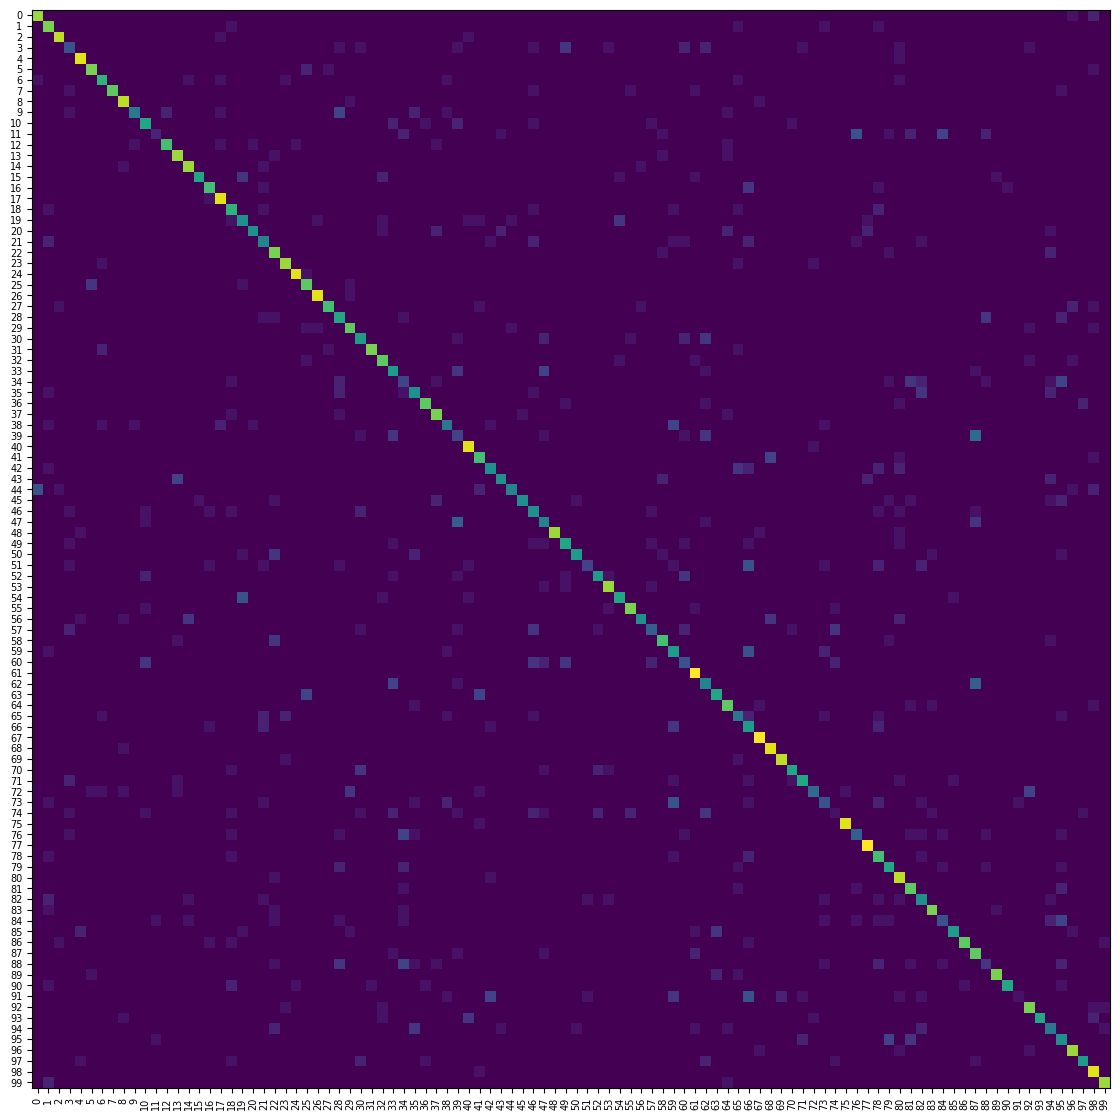

In [44]:
conf_matrix = confusion_matrix(df_val['Class'], predictions)

plt.figure(figsize=(14, 14))
plt.imshow(conf_matrix)
plt.xticks(np.arange(len(conf_matrix)), fontsize=7, rotation='vertical')
plt.yticks(np.arange(len(conf_matrix)), fontsize=7)

plt.show()

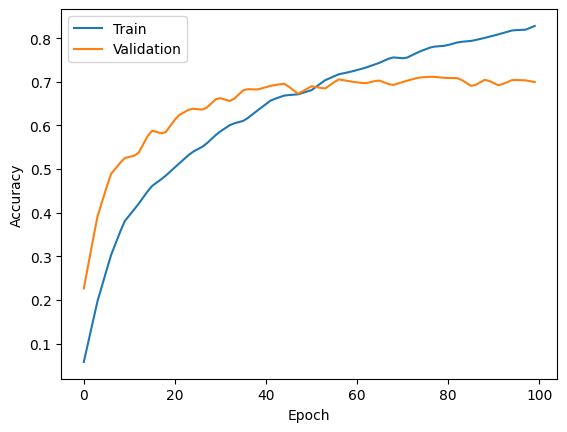

In [92]:
plt.plot(train_epochs, label='Train')
plt.plot(test_epoch, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()